# Project Overview
# Classifying Patient-Ventilator Asynchronies
This machine learning (ML) project aims to segment and classify **Patient-Ventilator Asynchronies (PVAs)** by analyzing bio-signal data from a mechanical ventilation. For the timebeing the data is extracted from artificial lung assesed for quality assurance of respiratory care devices. <br>
 Data source: **Google Brain**: [Kaggle](https://www.kaggle.com/competitions/ventilator-pressure-prediction)<br>
 Scientific Basis: **ScinceDirect**: [Patient-ventilator asynchrony classification in mechanically ventilated patients: Model-based or machine learning method](https://www.sciencedirect.com/science/article/pii/S016926072400316X)<br>
 PVAs are mismatches between patient breathing effort and ventilator support, which can lead to respiritory ventilation associated trauma, if not addressed.

---

# Data Analysis: Ventilator to Artificial Lung
Data was collected from a simulated setup connecting a **mechanical ventilator** to an **artificial lung**. 

- **Signal Types Collected**: 
  - Airway Pressure (Paw) 
  - Flow Rate
  - Volume
  - Optional: Derived parameters like compliance or resistance

- **Objective**: Explore the raw time-series data to identify potential features indicative of synchrony or asynchrony events.

---

# **Feature Engineering**
Custom features were extracted from the raw signals to capture meaningful patterns and anomalies. These features included:

- **Statistical and geometrical features**: mean, variance, skewness, kurtosis of flow/pressure...
- **Shape descriptors**: waveform slopes, rise times, fall times
- **Peak detection**: Number and amplitude of pressure and flow peaks
- **Temporal segmentation**: Division of signals into breathing cycles

---

# Experimentation: **Unsupervised Learning**: Clustering with Self-Organizing Maps (SOM)
Before labeling the data, **Self-Organizing Maps (SOM)** were applied as an unsupervised learning method to visualize and group the signal patterns into clusters:

- **Purpose**:
  - Discover natural groupings in the data
  - Support exploratory data analysis
  - Assist in semi-automatic labeling

- **Output**: Clusters that group similar waveform patterns together, offering insights into which might represent different PVA types or normal breathing.

---
# Experimentation: **Unsupervised Learning**: HDBSCAN
- **Purpose**:
  - Discover natural groupings in the data
  - Support exploratory data analysis
  - Assist in semi-automatic labeling
- **Output**: Clusters that group similar waveform patterns together, offering insights into which might represent different PVA types or normal breathing.

# **Label Engineering**
Using the results from SOM clustering and domain knowledge:

- **Labels were assigned** to the breathing cycles based on characteristic patterns of known asynchrony types:
  - Ineffective effort
  - Double triggering
  - Flow mismatch
  - Normal cycles

Manual verification was used to ensure accuracy.

---

# **Supervised Learning**: Classification with XGBoost
After labeling, a **XGB classifier** was trained to predict the type of event (PVA or not) based on the engineered features.

- **Why XGB?**
  - Robust to overfitting
  - Handles non-linear relationships
  - Feature importance analysis is built-in

- **Training/Validation Split**: A portion of the dataset was held out for validation to assess generalization.

---

# 📈 Performance Analysis
The classifier’s performance was evaluated using standard metrics:

- **Accuracy**
- **Precision / Recall / F1 Score**
- **Confusion Matrix**
- **ROC AUC Curve** (if treated as a binary classification)

These metrics helped identify class imbalances, false positives/negatives, and overall reliability of the model in real-world applications.

---

# ✅ Conclusion
This ML pipeline demonstrates a robust framework for classifying PVAs using real-time ventilator signals.
- XGB calssifier achives .99% accuracy on the synthetic dataset.
- Forwarding to real clinical data.


In [24]:
#--<Python Standard Libs>--
import time, warnings
import sys, os, subprocess
from dataclasses import dataclass, field
from typing import List, Tuple
import joblib
import pip
import pickle

# --<DataScience>--
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull, QhullError
from scipy.fft import fft

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from scipy.interpolate import PchipInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# --<Feature Engineering>--
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from scipy.interpolate import BSpline, splrep


# --<Machine Learning>--
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from minisom import MiniSom


from dataclasses import dataclass, field

assert sys.version_info >= (3, 5)

In [ ]:
plt.style.use('dark_background')
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

new_datasets_path:str = ""
image_path:str = ""
root: str = ""
dataset_path : str = ""
Save_path = ""

# Dataset Analysis

In [3]:
def Load_Dataset(dataset_path:str)-> pd.DataFrame:
    os.chdir(dataset_path)
    train_dataset = pd.read_csv("train.csv")
    test_dataset = pd.read_csv("test.csv")
    Final_Dataset = full_df = pd.concat([train_dataset, test_dataset], axis=0, ignore_index=True)
    return Final_Dataset

In [27]:
os.chdir(new_datasets_path)
dataset = pd.read_csv("original_data.csv")

In [28]:
dataset.shape[0]

910080

In [29]:
np.unique(dataset['R'])

array([ 5, 20, 50])

In [30]:
np.unique(dataset['breath_id'], return_counts = True)

(array([     3,      7,     10, ..., 125734, 125736, 125740],
       shape=(11376,)),
 array([80, 80, 80, ..., 80, 80, 80], shape=(11376,)))

In [11]:
dataset.groupby('breath_id')
dataset.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
160,161,3,50,20,0.000000,0.000000,0,5.064168
161,162,3,50,20,0.031964,7.187242,0,5.064168
162,163,3,50,20,0.063952,13.338781,0,6.751420
163,164,3,50,20,0.095892,17.111335,0,12.305289
164,165,3,50,20,0.127871,18.353980,0,18.702784


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910080 entries, 160 to 6035679
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         910080 non-null  int64  
 1   breath_id  910080 non-null  int64  
 2   R          910080 non-null  int64  
 3   C          910080 non-null  int64  
 4   time_step  910080 non-null  float64
 5   u_in       910080 non-null  float64
 6   u_out      910080 non-null  int64  
 7   pressure   910080 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 62.5 MB


In [14]:
data = dataset.groupby(["breath_id"])

>> ## Feature engineering and Interpolation

In [31]:
standardize_cols = ['u_in', 'time_step', 'pressure']
shift_range = range(1, 6)

for col in standardize_cols:
    std_col = f'{col}_std'
    dataset[std_col] = data[col].transform(lambda x: (x - x.mean()) / x.std())

for n in shift_range:
    for col in ['u_out'] + [f'{col}_std' for col in standardize_cols]:
        base_name = col.replace('_std', '') if col.endswith('_std') else col
        dataset[f'{base_name}_after{n}'] = data[col].shift(n)
        dataset[f'{base_name}_back{n}'] = data[col].shift(-n)


In [44]:
dataset.drop(dataset.columns[[0]], axis=1, inplace=True)

In [33]:
dataset.fillna(0, inplace = True)
dataset.head(80)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_std,time_step_std,...,pressure_after4,pressure_back4,u_out_after5,u_out_back5,u_in_after5,u_in_back5,time_step_after5,time_step_back5,pressure_after5,pressure_back5
0,161,3,50,20,0.000000,0.000000,0,5.064168,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,162,3,50,20,0.031964,7.187242,0,5.064168,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,163,3,50,20,0.063952,13.338781,0,6.751420,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,164,3,50,20,0.095892,17.111335,0,12.305289,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,165,3,50,20,0.127871,18.353980,0,18.702784,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,236,3,50,20,2.397749,4.944269,1,6.610815,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,237,3,50,20,2.429649,4.952485,1,6.681117,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,238,3,50,20,2.461564,4.959494,1,6.048398,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,239,3,50,20,2.493380,4.965451,1,6.470211,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def Draw_ScatterMatrix(dataset: pd.DataFrame):    
    set_attributes: list = ["pressure", "u_out", "u_in","R", "C", "time_step"]
    scatter_matrix(dataset[set_attributes], figsize=(12,8))

># ⚠️ **Conditional Warning: Time-Intensive Operation**

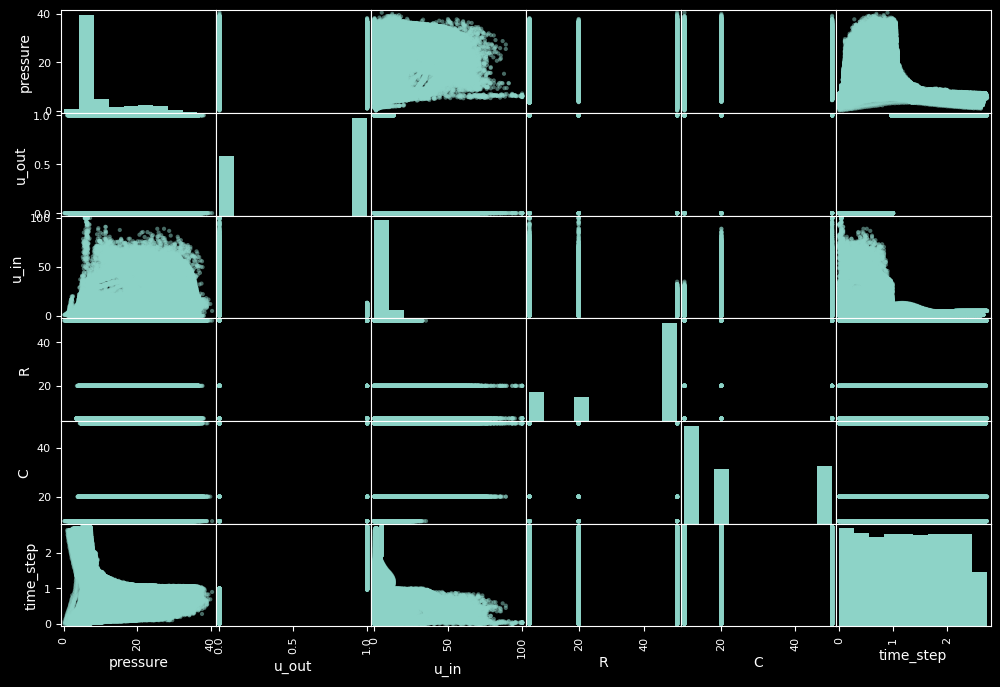

In [19]:
Draw_ScatterMatrix(dataset)

In [22]:
os.chdir(image_path)

<img src="./Scatter_Matrix.png" alt="" style="opacity: 1;" />

# Generating DataSets

In [34]:
#Saving Timeshifted Dataset
os.chdir(new_datasets_path)
dataset.to_csv("TS_Data.csv")

> #  Extration of Geometrical properties

In [35]:
print(dataset.columns.to_list())

['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure', 'u_in_std', 'time_step_std', 'pressure_std', 'u_out_after1', 'u_out_back1', 'u_in_after1', 'u_in_back1', 'time_step_after1', 'time_step_back1', 'pressure_after1', 'pressure_back1', 'u_out_after2', 'u_out_back2', 'u_in_after2', 'u_in_back2', 'time_step_after2', 'time_step_back2', 'pressure_after2', 'pressure_back2', 'u_out_after3', 'u_out_back3', 'u_in_after3', 'u_in_back3', 'time_step_after3', 'time_step_back3', 'pressure_after3', 'pressure_back3', 'u_out_after4', 'u_out_back4', 'u_in_after4', 'u_in_back4', 'time_step_after4', 'time_step_back4', 'pressure_after4', 'pressure_back4', 'u_out_after5', 'u_out_back5', 'u_in_after5', 'u_in_back5', 'time_step_after5', 'time_step_back5', 'pressure_after5', 'pressure_back5']


In [36]:
import pandas as pd
import numpy as np
from scipy.fft import rfft
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError

def Terraform_DataSet(group: pd.DataFrame):
    features = {}
    breath_id = group['breath_id'].iloc[0]
    
    u_in_col, u_out_col, p_col = "u_in", "u_out", "pressure"
    
    mask = group[[u_in_col, u_out_col, p_col]].notna().all(axis=1)
    valid_group = group.loc[mask]
    
    if len(valid_group) < 2:
        return pd.DataFrame([features]).assign(breath_id=breath_id)
    
    TV = valid_group[u_in_col].to_numpy() + valid_group[u_out_col].to_numpy()
    P = valid_group[p_col].to_numpy()
    
    features["Polynomial_Area"] = np.abs(np.trapz(P, TV))
    
    
    if len(TV) >= 3:
        try:
            hull = ConvexHull(np.column_stack((TV, P)))
            features["Hull_Area"] = hull.volume
        except QhullError:
            features["Hull_Area"] = 0.0
    else:
        features["Hull_Area"] = 0.0
    
    for name, arr in [('TV', TV), ('P', P)]:
        ft = np.abs(rfft(arr))[:5]
        for i, val in enumerate(ft, 1):
            features[f"ft_{name}_{i}"] = val
    
    diffs = np.diff(np.column_stack((TV, P)), axis=0)
    features.update({
        "Perimeter": np.sum(np.hypot(diffs[:, 0], diffs[:, 1])),
        "Width": np.ptp(TV),
        "Height": np.ptp(P),
        "Centroid_X": TV.mean(),
        "Centroid_Y": P.mean(),
    })
    
    # 5) Curvature Calculation
    dx = np.gradient(TV)
    dy = np.gradient(P)
    ddx, ddy = np.gradient(dx), np.gradient(dy)
    with np.errstate(divide='ignore', invalid='ignore'):
        curvature = np.nanmean(np.abs(dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5)
    features["Curvature"] = curvature if not np.isnan(curvature) else 0.0

    return pd.DataFrame([features]).assign(breath_id=breath_id)

def Feature_Engineering(df: pd.DataFrame):
    # Memory-efficient processing
    features = pd.concat(
        [Terraform_DataSet(g) for _, g in df.groupby('breath_id', sort=False)],
        ignore_index=True
    )
    return df.merge(features, on='breath_id', how='left')

In [42]:
dataset = pd.read_csv("TS_Data.csv")

In [45]:
dataset.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_std,time_step_std,...,pressure_after4,pressure_back4,u_out_after5,u_out_back5,u_in_after5,u_in_back5,time_step_after5,time_step_back5,pressure_after5,pressure_back5
0,161,3,50,20,0.000000,0.000000,0,5.064168,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,162,3,50,20,0.031964,7.187242,0,5.064168,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,163,3,50,20,0.063952,13.338781,0,6.751420,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,164,3,50,20,0.095892,17.111335,0,12.305289,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,165,3,50,20,0.127871,18.353980,0,18.702784,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

> # Saving Timeseries data with full gemometrical extactions


In [46]:
dataset = Feature_Engineering(dataset)

In [47]:
dataset.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_std,time_step_std,...,ft_P_2,ft_P_3,ft_P_4,ft_P_5,Perimeter,Width,Height,Centroid_X,Centroid_Y,Curvature
0,161,3,50,20,0.000000,0.000000,0,5.064168,0.0,0.0,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
1,162,3,50,20,0.031964,7.187242,0,5.064168,0.0,0.0,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
2,163,3,50,20,0.063952,13.338781,0,6.751420,0.0,0.0,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
3,164,3,50,20,0.095892,17.111335,0,12.305289,0.0,0.0,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
4,165,3,50,20,0.127871,18.353980,0,18.702784,0.0,0.0,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253


> # Saving Only Geometrical properties

In [48]:
dataset.drop(dataset.columns[[0,2,3,4,5,6,7,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]], axis=1, inplace=True)
dataset.head()

,breath_id,u_in_std,pressure_std,Polynomial_Area,Hull_Area,ft_TV_1,ft_TV_2,ft_TV_3,ft_TV_4,ft_TV_5,...,ft_P_2,ft_P_3,ft_P_4,ft_P_5,Perimeter,Width,Height,Centroid_X,Centroid_Y,Curvature
0,3,0.0,0.0,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
1,3,0.0,0.0,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
2,3,0.0,0.0,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
3,3,0.0,0.0,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253
4,3,0.0,0.0,282.157479,350.167422,484.607933,183.391093,68.468914,56.159057,51.404353,...,409.824319,164.998616,67.671789,116.198749,122.759376,18.35398,22.777895,6.057599,13.534698,11.190253


In [49]:
os.chdir(new_datasets_path)
temp_dataset = dataset.groupby('breath_id', as_index=False).first()
temp_dataset.to_csv("GeometricalProperties.csv")